# Fine Tuning For BERT Models with TPU

In [ ]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# With this code, 8 TPU cores are allocated.

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

# To take advantage of the speed of TPU cores, we assign the 8 allocated TPU cores to the strategy variable.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
#To use BERT models, we first need to install transformers as BERT models are built on top of transformers.

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### **Reading Data for Intent Classification**

The data contains various user queries categorized into seven

https://github.com/sonos/nlu-benchmark/tree/master/2017-06-custom-intent-enginesintents

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/classification.csv")
df.head()

text         intent
0   listen to westbam alumb allergic on google music      PlayMusic
1         add step to me to the 50 clásicos playlist  AddToPlaylist
2  i give this current textbook a rating value of...       RateBook
3               play the song little robin redbreast      PlayMusic
4  please add iris dement to my playlist this is ...  AddToPlaylist

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14484 non-null  object
 1   intent  14484 non-null  object
dtypes: object(2)
memory usage: 226.4+ KB


In [ ]:
print('df size :', df.shape)

df size : (14484, 2)


In [ ]:
sum(df.duplicated())

# There are 268 duplicated rows in corpus

268

In [ ]:
df=df.drop_duplicates()

# we remove the duplicated rows

In [ ]:
df.isnull().sum()

# There aren't missing values

text      0
intent    0
dtype: int64

In [ ]:
df.reset_index(drop=True, inplace=True)

# We reset the index because we remove duplicated rows.

In [ ]:
df.intent.value_counts()

GetWeather              2086
BookRestaurant          2068
PlayMusic               2064
SearchCreativeWork      2051
AddToPlaylist           2035
RateBook                1991
SearchScreeningEvent    1921
Name: intent, dtype: int64

In [ ]:
df.intent.value_counts(normalize=True)

GetWeather              0.146736
BookRestaurant          0.145470
PlayMusic               0.145189
SearchCreativeWork      0.144274
AddToPlaylist           0.143149
RateBook                0.140053
SearchScreeningEvent    0.135129
Name: intent, dtype: float64

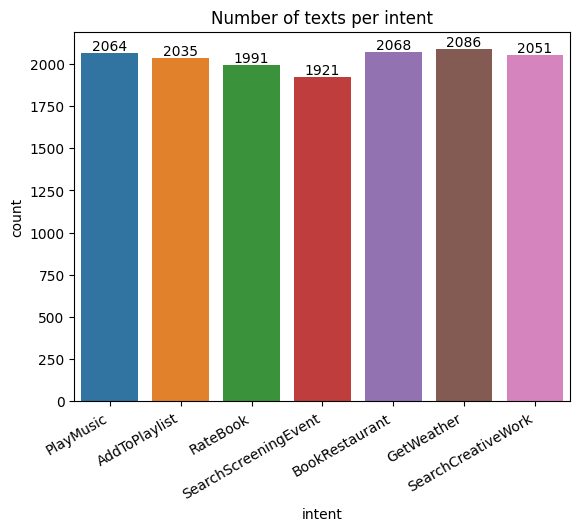

In [ ]:
chart = sns.countplot(x= "intent", data=df)
chart.bar_label(chart.containers[0])
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

## Converting Labels to Numeric Form

In [ ]:
X = df['text']
y = df['intent']

In [ ]:
y.head()

0        PlayMusic
1    AddToPlaylist
2         RateBook
3        PlayMusic
4    AddToPlaylist
Name: intent, dtype: object

In [ ]:
unique_labels = df['intent'].unique()
unique_labels

# There are a total of 7 unique classes in the target.

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [ ]:
label_dict = dict()

for i, label in enumerate(unique_labels):
    label_dict[label] = i

label_dict

# We need to convert the unique classes in our target into numeric version first, and then convert them into a matrix.
# First, we determine which classes will be assigned to which numbers.

{'PlayMusic': 0,
 'AddToPlaylist': 1,
 'RateBook': 2,
 'SearchScreeningEvent': 3,
 'BookRestaurant': 4,
 'GetWeather': 5,
 'SearchCreativeWork': 6}

In [ ]:
y = y.map(label_dict)
y.head()

# We assign numbers to classes according to the label_dict using the map function

0    0
1    1
2    2
3    0
4    1
Name: intent, dtype: int64

 ## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Tokenization Example For BERT

https://huggingface.co/bert-base-cased

https://huggingface.co/bert-base-uncased

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# We can take the necessary codes for setting up the tokenizer and model from the huggingface bert cased link I left above and use them here.
# We assign the code we will use for tokenizer operations to a variable called tokenizer.

In [ ]:
tokenizer.vocab

OrderedDict([('[PAD]', 0),
             ('[unused1]', 1),
             ('[unused2]', 2),
             ('[unused3]', 3),
             ('[unused4]', 4),
             ('[unused5]', 5),
             ('[unused6]', 6),
             ('[unused7]', 7),
             ('[unused8]', 8),
             ('[unused9]', 9),
             ('[unused10]', 10),
             ('[unused11]', 11),
             ('[unused12]', 12),
             ('[unused13]', 13),
             ('[unused14]', 14),
             ('[unused15]', 15),
             ('[unused16]', 16),
             ('[unused17]', 17),
             ('[unused18]', 18),
             ('[unused19]', 19),
             ('[unused20]', 20),
             ('[unused21]', 21),
             ('[unused22]', 22),
             ('[unused23]', 23),
             ('[unused24]', 24),
             ('[unused25]', 25),
             ('[unused26]', 26),
             ('[unused27]', 27),
             ('[unused28]', 28),
             ('[unused29]', 29),
             ('[unused30]', 30),
 

In [ ]:
print(len(tokenizer.vocab))

# There are 28996 unique tokens in BERT cased model

28996


In [ ]:
tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')

# We will always use the uncased model for classification and sentiment analysis problems.

In [ ]:
print(len(tokenizer2.vocab))

# There are 30522 unique tokens in BERT uncased model

30522


In [ ]:
text = "Careless driver and student ended up with some hospitalization 🏥."
print(tokenizer.tokenize(text))

# An example of word piece tokenization according to cased tokenization
# [UNK] token has been assigned for the hospital emoji

['Care', '##less', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '[UNK]', '.']


In [ ]:
text = "Careless driver and student ended up with some hospitalization 🏥."
print(tokenizer2.tokenize(text))

# An example of word piece tokenization according to uncased tokenization
# [UNK] token has been assigned for the hospital emoji

['careless', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '[UNK]', '.']


In [ ]:
input_ids = tokenizer.encode(text, add_special_tokens=True) # default add_special_tokens=True
print(input_ids)

# tokenizer.encode(text, add_special_tokens=True)" returns input_ids by adding special tokens at the beginning and end of the text.

[101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102]


In [ ]:
print(tokenizer.convert_tokens_to_ids(['Care', '##less', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '.']))

# convert_tokens_to_ids" converts the tokens into token numbers in the memory of the BERT model.

[8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 119]


In [ ]:
print(tokenizer.convert_tokens_to_string(['Care', '##less', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '.']))

# convert_tokens_to_string" converts the tokens into a text (string) by concatenating them

Careless driver and student ended up with some hospitalization .


In [ ]:
tokenizer.decode(input_ids)

# The 'decode' code is used to convert numeric tokens given as 'input_ids' into text.
# This process allows for the conversion of numeric tokens back into their original text form.

'[CLS] Careless driver and student ended up with some hospitalization [UNK]. [SEP]'

In [ ]:
input_ids = tokenizer.encode(text, add_special_tokens=True) # default add_special_tokens=True
print(input_ids)
print(tokenizer.encode_plus(text, add_special_tokens=True)) # default add_special_tokens=True

# tokenizer.encode(text, add_special_tokens=True)" returns input_ids by adding special tokens at the beginning and end of the text.
# The code "tokenizer.encode_plus(text, add_special_tokens=True)" converts the text into three separate vectors: input_ids, token_type_ids, and
# attention_mask.

# The tokenizer.encode function converts our text into a numeric version, similar to how it is done in DL models.

# Special tokens indicating the start-[CLS] and end-[SEP] points of the sentence/text are added to each text.

# The numeric version of the text, which is converted into token embeddings vectors, is called input_ids in BERT models.

# However, BERT models do not only require the token embeddings (input_ids) vector as input.They require three separate vectors:token embeddings (input_ids),
# segment embeddings (token_type_ids), and attention_mask.

# Token embeddings convert the tokens into numeric form based on their position in the BERT model's memory, similar to how it is done in DL models.

# Segment embeddings are used in tasks such as translation, question-answering, and sentence similarity. For example, in a translation task, the model
# needs to understand which part of the text is in Turkish and which part is in English, and it helps the model establish semantic relationships between
# tokens in these two different text structures. The Turkish part is represented by 0s, while the English part is represented by 1s (or vice versa).

# Position embeddings provide the model with information about the position of tokens in the text. This allows the model to establish semantic
# relationships based on the order of tokens.

# The position embedding vector is not a separate vector like the others mentioned above. It is added to the word embedding vectors of tokens in the text.
# By doing so, the model learns the order of tokens while reading their word embeddings.

# The attention_mask provides information to the model about which tokens to process. The model performs operations only on tokens with a value of 1,
# while tokens with a value of 0 are not processed.

# However, segment embeddings are not used in tasks such as classification, sentiment analysis, and named entity recognition (NER).

[101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102]
{'input_ids': [101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokenizer.encode_plus(text).keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(tokenizer.encode_plus(text)['input_ids'])

[101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102]


### Fixing token counts of all documents

In [ ]:
# For every sentence...
number_tokens_sentences = []
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer2.encode(sent, add_special_tokens=True) # we use tokenizer2 for uncased
    number_tokens_sentences.append(len(input_ids))

print('Max sentence length: ', max(number_tokens_sentences))

# We will use the 'tokenizer.encode()' function to find out how many tokens the longest comment consists of and to decide on the number
# of tokens to fix for all documents/texts.

Max sentence length:  38


In [ ]:
np.array(number_tokens_sentences).mean()

12.127250984805853

In [ ]:
token_size = 24
sum(np.array(number_tokens_sentences) < token_size) / len(number_tokens_sentences)

# We will fix all documents to size 24.

0.9915588069780529

### Transformation Vectors to Matrices

In [ ]:
text = "Careless driver and student ended up with some hospitalization 🏥."
tokens = tokenizer2.encode_plus(text, add_special_tokens=True)
print(tokens)

# The "tokenizer.encode_plus()" function converts the text into token embeddings (input_ids), segment embeddings (token_type_ids), and attention_mask
# vectors as required by BERT models.

# Similar to what we did in "tokenizer.encode()", special tokens indicating the start-[CLS] and end-[SEP] points of the sentence/text are added to each
# text here as well.

# IMPORTANT NOTE: Only embeddings (input_ids) and attention_mask are used in BERT classification, sentiment analysis, and Named Entity
# Recognition (NER) tasks.

{'input_ids': [101, 23358, 4062, 1998, 3076, 3092, 2039, 2007, 2070, 2902, 3989, 100, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.encode_plus(text, max_length=24, truncation=True,
                              padding='max_length', add_special_tokens=True)
tokens

# Since we decided to fix the texts to 24 tokens, we perform truncation (truncation=True) and padding (padding='max_length') operations to all texts to
# be 24 tokens by giving max_length=24, truncation=True, padding='max_length' parameters inside the tokenizer.encode_plus() function. The point we need to
# pay attention to here is that we are not using padding = True, instead we use padding='max_length'.

# Also, texts will be fixed to 24 tokens with the addition of [CLS] and [SEP] special tokens.

# As you can see, all three vectors are fixed to 24 tokens. We do not forget that in classification problems, segment embeddings (token_type_ids) will be
# a vector consisting only of zeros, so they are not used in classification problems

{'input_ids': [101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
np.array(tokens["input_ids"])

array([ 101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704,
       2734,  100,  119,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

In [ ]:
np.array(tokens["attention_mask"])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
# Since our task is classification, we need to obtain two separate matrices consisting of token embeddings (input_ids) and attention_mask vectors.

# For this, we first create empty lists for input_ids and attention_mask, then pull all rows/documents from X one by one with a for loop and append
# the input_ids, attention_mask vectors we obtained from these documents into the empty lists. In the final step, we convert these lists into
# matrices of size (number of rows, fixed token number) --> (len(X), 24) with the array() function.

def transformation(X):
  # set array dimensions
  seq_len = 24

  # We create an empty list Xids for input_ids vectors and an empty list Xmask for attention_mask vectors.
  Xids = []
  Xmask = []


  for text in X: # We are pulling all lines/documents from the corpus in order.

      tokens = tokenizer2.encode_plus(text, max_length=seq_len, truncation=True,      # we use tokenizer2 for uncased
                                      padding='max_length', add_special_tokens=True)
      # We are converting each text we pull from the corpus into vectors.

      # assign tokenized outputs to respective rows in numpy arrays
      Xids.append(tokens['input_ids']) # We are appending the input_ids vector corresponding to each line/document to the Xids list.
      Xmask.append(tokens['attention_mask']) # We are appending the attention_mask vector corresponding to each line/document to the Xmask list.


  return np.array(Xids), np.array(Xmask) # We are converting the Xids and Xmask matrices (row number, 24) into array format for faster operation.

In [ ]:
Xids_train, Xmask_train = transformation(X_train)

# We are creating 2 separate matrices for our training set.

Xids_test, Xmask_test = transformation(X_test)
# We are creating 2 separate matrices for our test set.

In [ ]:
Xids_train

array([[ 101, 2424, 2033, ..., 2538, 1013,  102],
       [ 101, 1045, 1040, ...,    0,    0,    0],
       [ 101, 1045, 2342, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 1040, ...,    0,    0,    0],
       [ 101, 2054, 2051, ...,    0,    0,    0],
       [ 101, 2507, 2033, ...,    0,    0,    0]])

In [ ]:
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_test.shape   :", Xids_test.shape)
print("Xmask_test.shape  :", Xmask_test.shape)

Xids_train.shape  : (12794, 24)
Xmask_train.shape : (12794, 24)
Xids_test.shape   : (1422, 24)
Xmask_test.shape  : (1422, 24)


In [ ]:
y_train

8451     4
3759     4
3960     4
9488     1
16       4
        ..
3920     4
1797     6
14005    1
6303     3
14007    3
Name: intent, Length: 12794, dtype: int64

In [ ]:
from tensorflow.keras.utils import to_categorical

labels_train=to_categorical(y_train, 7)
labels_train

# we convert the y_train to a matrix

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
labels_test=to_categorical(y_test, 7)
labels_test

# we convert the y_test to a matrix

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Transformation Matrix to Tenserflow Tensor

In [ ]:
import tensorflow as tf

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_train

# The final step before feeding the data into BERT models is to convert the matrices we obtained above into grouped TensorFlow tensors.

# A tensor is a mathematical structure that represents a collection of data in one or more dimensions. A one-dimensional tensor is represented as a vector,
# a two-dimensional tensor as a matrix, and tensors with three or more dimensions are referred to as high-dimensional tensors.

# TensorFlow tensors enable faster execution on hardware such as GPUs/TPUs and allow for more efficient processing of operations such as parallel computing.

# TensorFlow tensors can also utilize the automatic differentiation features provided by the TensorFlow library. However, numpy.array() cannot perform
# these operations, so we convert them to tensors using the TensorFlow library.

# Additionally, the tf.data.Dataset.from_tensor_slices function converts the Xids_train, Xmask_train, and labels_train tensors into triple grouped tensors.
# This way, the model will understand that these three tensors represent a single row.

# In this context, we will convert our three separate matrices obtained for the training data into grouped TensorFlow tensors.


<_TensorSliceDataset element_spec=(TensorSpec(shape=(24,), dtype=tf.int64, name=None), TensorSpec(shape=(24,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_test

#We convert the tensors Xids_train, Xmask_train, and labels_train into triple grouped tensors, just like we did with the training data.


<_TensorSliceDataset element_spec=(TensorSpec(shape=(24,), dtype=tf.int64, name=None), TensorSpec(shape=(24,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

In [ ]:
def map_func(Tensor_Xids, Tensor_Xmask, Tensor_labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}, Tensor_labels

# Which of the tensors we obtained above is 'input_ids', which is 'attention_mask', and which is 'labels' the model does not know. Therefore, we need
# to provide this information to our model. We define the map_func function for this purpose.

# We define 'input_ids' and 'attention_mask' within the dictionary. We leave the labels outside the dictionary.

In [ ]:
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

# then we use the dataset map method to apply this transformation

In [ ]:
dataset_train

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(24,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(24,), dtype=tf.int64, name=None)}, TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

In [ ]:
dataset_test

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(24,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(24,), dtype=tf.int64, name=None)}, TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

## Batch Size Train and Validation Dataset

In [ ]:
batch_size = 16

# The developers who developed the BERT model recommend using batch sizes of 16 and 32.

train_ds = dataset_train.batch(batch_size)
val_ds = dataset_test.batch(batch_size)

# We determine in how many batches we will feed the grouped tensors obtained above to the model. We do this using the batch() function.
# We want the model to be fed in batches of 32. We apply this to both the train and test data.

In [ ]:
train_ds

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 24), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 24), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
!pip install -q tf-models-official

In [ ]:
len(X_train)

12794

In [ ]:
len(X_train)/16

799.625

In [ ]:
print(len(train_ds))
print(len(train_ds)*3)
print(int(0.1*len(train_ds)*3))

800
2400
240


In [ ]:
from official.nlp import optimization
epochs = 3
#batch_size = 16
steps_per_epoch = len(train_ds)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5  # 3e-5, 5e-5
optimizer= optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# The Num_warmup_steps (warm-up step count) determines how the learning rate of the optimizer to be used in the training process of a model in
# an optimization process will be determined. The learning rate determines how fast the model will learn and update during the training process.
# A very high learning rate can cause the model to learn quickly during the training process, but it can also increase the risk of overfitting
# the model. A very low learning rate can cause the model to fail to learn.

# Num_warmup_steps ensures that the learning rate of the optimizer in the training process of the model is low at the beginning of the training
# process and gradually increases as the training process progresses. This way, there is a lower risk of the model making mistakes at a lower rate
# during the training process and the training process of the model progresses more regularly. This allows the model to perform better.


# steps_per_epoch shows how many steps an epoch will be completed. len(train_ds) = 800 --> len(train_ds) number shows how many 16-piece packets/steps
# the train_data consists of.

# IMPORTANT NOTE: The last packets/steps in the train data may consist of less than 16 observations. For example, there are 10 observations in the last
# packet/step of this train_ds data. However, even if there are less than 16 observations, we still count them as a packet/step.

# num_train_steps shows how many steps the training will be completed in total. Since the training will be completed in 3 epochs,
# steps_per_epoch(len(train_ds)) * epochs --> 800 * 3 = 2400, num_warmup_steps is recommended to be taken as 10% of num_train_steps (2400x0.1 = 240).
# However, you can observe your scores by reducing/increasing this rate a little more. The fact that num_warmup_steps is 240 means the following.
# When the model starts training, it does not start training directly with the learning rate of 2e-5 that we gave into the optimization.create_optimizer
# function.
# In the first 240 steps of the training, the learning rate is gradually increased to be between 0 and 2e-5, and after the 240th step, the training
# continues at a rate of 2e-5.
# This way, there is a lower risk of the model making mistakes at a lower rate during the training process and the training process of the model
# progresses more regularly. This allows the model to perform better.

# If you notice, we used the AdamW (Adam with Weight Decay) optimizer here. AdamW includes the weight decay feature in addition to the Adam optimizer.

# Weight decay allows the weights of the model to change less during the training process, thereby reducing the risk of overfitting.

# The learning rates recommended by developers in BERT models are 2e-5, 3e-5 and 5e-5.
# The number of epochs recommended by developers in BERT models is 2 or 3. Larger numbers cause overfitting.
# We need to observe by trial and error which learning rates and epoch numbers give better results.

## Creating Model

In [ ]:
def create_model():
    from transformers import TFBertModel
    from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
    from tensorflow.keras import Model

    model = TFBertModel.from_pretrained("bert-base-uncased")
    # We are copying the necessary code for model training from the Hugging Face page.
    # Since tokenization is done with "bert-base-uncased", we need to train with "bert-base-uncased" as well.
    # If we train with "bert-base-cased", our results will be poor.

    input_ids = Input(shape=(24,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(24,), name='attention_mask', dtype='int32')
    # Since our inputs consist of token embeddings (input_ids) and position embeddings (attention_mask), we create an input layer for each of them.
    # Since input_ids and attention_mask have a size of 24, we specify the dimensions of our input layers as (shape=(24,)) for each document/row.
    # Otherwise, we would get an error.

    # To distinguish these layers from each other, we use the names we specified in the map_func function as the names. If different names are used,
    # the model will return an error.
    # BERT models work with dtype="int32". Therefore, we specify dtype="int32". If a different type is used, we will get an error.

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]
    # he embeddings layer is the layer where we retrieve the word embeddings that have been previously trained and stored in the memory of the BERT model.
    # The retrieved word embeddings are then combined to convert them into sentence embeddings of size 768.
    # We will perform our training on the Dense layer to determine which class the obtained sentence embeddings belong to.

    x = Dense(160, activation='relu')(embeddings) # We are reducing the dimensionality from 768 to 160. We need to experiment to find the best number.
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x) # The recommended ratio by developers is 0.1.
    y = Dense(7, activation='softmax', name='outputs')(x) # Returning the output

    # If you noticed, here we are using the Functional API instead of the Sequential API.
    # In the Functional API, we transfer the information from the previous layer to the next layer by opening a tuple after the layer we want to
    # transfer and writing the name of the previous layer inside it.
    # To send the sentence embeddings obtained from the Embeddings layer to the Dense layer, we open a tuple after the Dense() layer and write
    # the name of the previous layer inside it.
    # Just like here, "Dense(160, activation='relu')(embeddings)". This way, the information from the embeddings layer is transferred to the Dense layer.
    # If you remember, this process was done as model.add(embeddings) in the Sequential API.

    return Model(inputs=[input_ids, attention_mask], outputs=y)
    # In the final stage, the inputs and outputs we obtained are defined within the Model function.

# The reason for building the model within a function is to make the operations we will perform under the strategy.scope() appear more concise.
# Otherwise, we would have to write all the code here under the strategy.scope().

In [ ]:
# We define all the operations we want to perform using the speed of the 8 TPU cores assigned to the strategy variable under the code block
# with strategy.scope()

with strategy.scope():

  #from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.losses import CategoricalCrossentropy
  from tensorflow.keras.metrics import Recall

  optimizer = optimizer
  #optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) ==> If we did not use the optimizer we defined above, we could also define
  # the optimizer in this way. However, there is a high risk of overfitting.
  loss = CategoricalCrossentropy()
  recall = Recall()
  model3 = create_model()
  model3.compile(optimizer=optimizer, loss=loss, metrics=[recall])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 24)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 24)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 24, 76                                       

In [ ]:
model3.fit(train_ds, validation_data= val_ds, epochs=epochs)

Epoch 1/3
800/800 [==============================] - 124s 71ms/step - loss: 0.8134 - recall: 0.6411 - val_loss: 0.1791 - val_recall: 0.9831
Epoch 2/3
800/800 [==============================] - 49s 61ms/step - loss: 0.3963 - recall: 0.8489 - val_loss: 0.1609 - val_recall: 0.9852
Epoch 3/3
800/800 [==============================] - 49s 61ms/step - loss: 0.3648 - recall: 0.8498 - val_loss: 0.1525 - val_recall: 0.9859


## Model evaluation

In [ ]:
model_loss = pd.DataFrame(model3.history.history)
model_loss.head()

loss    recall  val_loss  val_recall
0  0.813393  0.641082  0.179127    0.983122
1  0.396257  0.848914  0.160942    0.985232
2  0.364834  0.849773  0.152456    0.985935

<Axes: >

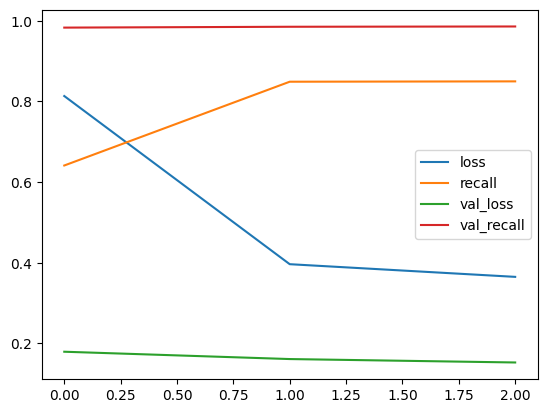

In [ ]:
model_loss.plot()

In [ ]:
model3.evaluate(train_ds)

800/800 [==============================] - 14s 16ms/step - loss: 0.0789 - recall: 0.9940


[0.07887047529220581, 0.9939815402030945]

In [ ]:
model3.evaluate(val_ds)

89/89 [==============================] - 2s 16ms/step - loss: 0.1525 - recall: 0.9859


[0.15245603024959564, 0.9859353303909302]

In [ ]:
y_pred = model3.predict(val_ds)

89/89 [==============================] - 10s 51ms/step


In [ ]:
y_pred

array([[2.25099339e-09, 6.01587535e-09, 4.32490177e-09, ...,
        4.15226831e-09, 1.00000000e+00, 4.51513715e-09],
       [1.07379146e-08, 7.75892506e-09, 2.81139889e-09, ...,
        5.71587488e-09, 1.16197727e-08, 2.12791775e-08],
       [3.61479580e-09, 1.38086129e-08, 1.00000000e+00, ...,
        2.17604139e-08, 7.18521065e-09, 8.78772877e-09],
       ...,
       [1.56376188e-07, 2.12514699e-08, 4.81826881e-08, ...,
        1.46236125e-08, 1.46459787e-08, 9.99999642e-01],
       [2.03889137e-08, 7.23399651e-08, 2.92456406e-08, ...,
        9.99999881e-01, 3.08197095e-08, 1.68245009e-08],
       [1.88787148e-04, 3.40871884e-05, 4.90806997e-05, ...,
        1.36322546e-04, 2.41491180e-05, 9.74689603e-01]], dtype=float32)

In [ ]:
y_prediction =  [np.argmax(i) for i in y_pred]
y_prediction[:3]

# In order for confusion_matrix and classification_report to work, y_test and y_pred must be 1-dimensional tensors (vectors).

# The code [np.argmax(i) for i in y_pred] is used to determine the index numbers with the highest probability values in each row of the y_pred matrix.
# These index numbers also represent the classes predicted by the model.

# The first 3 classes predicted by the model are shown below.

[5, 3, 2]

In [ ]:
y_test # y_test is 1-dimensional tensor (vector).

6327     5
10265    3
2028     2
10891    6
8442     4
        ..
10120    5
7837     0
9476     6
7016     4
8150     6
Name: intent, Length: 1422, dtype: int64

In [ ]:
y_pred_train = model3.predict(train_ds)

800/800 [==============================] - 11s 12ms/step


In [ ]:
y_prediction_train =  [np.argmax(i) for i in y_pred_train]
y_prediction_train[:3]

# We are performing the same operations on the training data as we did on the test data above.

[4, 4, 4]

In [ ]:
y_train # y_train is 1-dimensional tensor (vector).

8451     4
3759     4
3960     4
9488     1
16       4
        ..
3920     4
1797     6
14005    1
6303     3
14007    3
Name: intent, Length: 12794, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

print(confusion_matrix(y_test, y_prediction))
print("-------------------------------------------------------")
print(classification_report(y_test, y_prediction))

[[204   0   0   0   0   0   2]
 [  0 204   0   0   0   0   0]
 [  0   0 199   0   0   0   0]
 [  0   0   0 185   0   0   7]
 [  0   0   0   0 207   0   0]
 [  0   0   0   0   1 208   0]
 [  3   0   1   5   1   0 195]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       206
           1       1.00      1.00      1.00       204
           2       0.99      1.00      1.00       199
           3       0.97      0.96      0.97       192
           4       0.99      1.00      1.00       207
           5       1.00      1.00      1.00       209
           6       0.96      0.95      0.95       205

    accuracy                           0.99      1422
   macro avg       0.99      0.99      0.99      1422
weighted avg       0.99      0.99      0.99      1422



In [ ]:
print(confusion_matrix(y_train, y_prediction_train))
print("-------------------------------------------------------")
print(classification_report(y_train, y_prediction_train))

[[1854    1    0    0    1    0    2]
 [   3 1828    0    0    0    0    0]
 [   0    0 1792    0    0    0    0]
 [   1    0    0 1696    0    0   32]
 [   0    0    0    0 1861    0    0]
 [   0    0    0    0    8 1869    0]
 [  21    0    0    7    0    1 1817]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1858
           1       1.00      1.00      1.00      1831
           2       1.00      1.00      1.00      1792
           3       1.00      0.98      0.99      1729
           4       1.00      1.00      1.00      1861
           5       1.00      1.00      1.00      1877
           6       0.98      0.98      0.98      1846

    accuracy                           0.99     12794
   macro avg       0.99      0.99      0.99     12794
weighted avg       0.99      0.99      0.99     12794



In [ ]:
!pip install scikit-plot

89/89 [==============================] - 2s 13ms/step


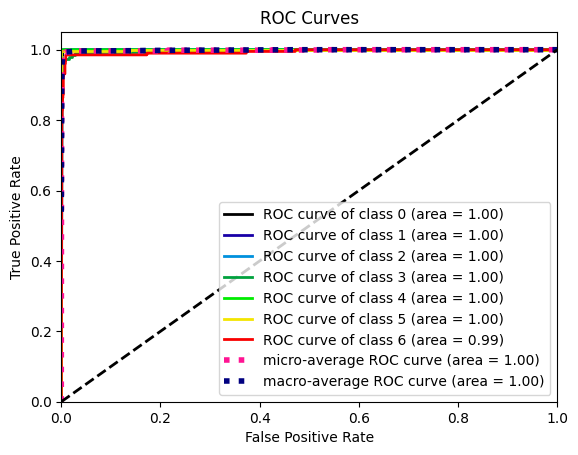

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

y_pred_proba = model3.predict(val_ds)

plot_roc(y_test, y_pred_proba) # y_test must be vector format and y_pred_proba must be matrix fromat
plt.show();

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba, multi_class='ovr') # multi_class parameter must be "ovr" or "ovo"

0.9985252929997152

## Model Saving

In [ ]:
model3.save_weights("/content/drive/MyDrive/classification_model.h5")

# We save the model weights/coefficients obtained after training by using the save_weights function and providing the drive path/name.
# Saving the coefficients will take up less space in Drive.

In [ ]:
with strategy.scope():

  model4 = create_model()
  model4.load_weights("/content/drive/MyDrive/classification_model.h5")

# We are rebuilding the BERT model that we defined under the create_model function before loading the model weights/coefficients we saved in Drive.
# We assign this model we built to the variable model4 and load the weights/coefficients into this untrained model.
# To take advantage of the speed of TPU cores of our newly created model4, we perform these operations under strategy.scope().

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Prediction

In [ ]:
# We apply the same procedures to the observations (obs) we will predict as we do to convert the train and test data into grouped tensorflow tensors.

def prep_data(text):
  import tensorflow as tf

  # 1. First, we convert the new observations we will predict into token embeddings (input_ids) and position embeddings (attention_mask) matrices.
  #    Remember that you need to run the transformation function first to use this function.
  Xids_obs, Xmask_obs = transformation(text)

  # 2. We convert our Xids_obs, Xmask_obs matrices into grouped tensorflow tensors.
  dataset_obs = tf.data.Dataset.from_tensor_slices((Xids_obs, Xmask_obs))

  # 3. We name the grouped tensorflow tensors we have converted as "input_ids" and "attention_mask" for the model to recognize.
  #    Since there is no label in the data we will predict, we do not define any labels.
  def map_func(Tensor_Xids, Tensor_Xmask):
       return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}

  dataset_obs = dataset_obs.map(map_func)

  # 4. As a final step, we batch our grouped tensorflow tensors into packets of 32, just like in the train data. Otherwise, we would get a shape mismatch
  # error.
  batch_size = 16 # We apply the batch_size used on the training data.
  obs_ds = dataset_obs.batch(batch_size)

  return obs_ds

In [ ]:
text1 = "please play the most popular songs"
text2 = "I will give 0 star to the book I am reading now"
text3 = "Find me the best movies"
text4 = "I'd like to watch the best actor movie"
text5 = "Need to make a reservation for 4."

texts = [text1, text2, text3, text4, text5]

In [ ]:
obs_ds = prep_data(texts)

# We are converting our texts into grouped TensorFlow tensors.

In [ ]:
probs = model4.predict(obs_ds)
probs

# We see probabilities.

1/1 [==============================] - 8s 8s/step


array([[1.0000000e+00, 6.3492704e-09, 1.3231373e-09, 5.4526095e-09,
        1.0135892e-09, 2.0644761e-09, 4.3519228e-09],
       [2.9636829e-09, 9.8289048e-09, 1.0000000e+00, 2.1096036e-09,
        1.4356428e-08, 4.5717230e-09, 5.7078307e-09],
       [2.8069263e-07, 8.3116461e-08, 1.5889866e-07, 9.9998868e-01,
        1.3482158e-07, 6.4282418e-08, 1.0634407e-05],
       [2.3566492e-06, 1.0078204e-06, 1.6098300e-06, 9.9836558e-01,
        1.6145046e-06, 7.0710024e-07, 1.6270939e-03],
       [2.6810900e-08, 8.1063128e-08, 3.9259099e-08, 6.2406798e-08,
        9.9999976e-01, 2.7298874e-08, 1.4760789e-08]], dtype=float32)

In [ ]:
classes = []
probas = []
for i in probs:
    classes.append(np.argmax(i))
    probas.append(max(i))

# We determine the predicted classes using the index number of the maximum value of probabilities in each row, and we determine with what probability
# the model predicted those classes using the highest probability value.

In [ ]:
my_dict = {"Review":texts, "prob":probas, "classes":classes}

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

Review      prob  classes
0               please play the most popular songs  1.000000        0
1  I will give 0 star to the book I am reading now  1.000000        2
2                          Find me the best movies  0.999989        3
3           I'd like to watch the best actor movie  0.998366        3
4                Need to make a reservation for 4.  1.000000        4